## Node2vec

Node2vec is a method based on the idea first implemented in the DeepWalk algorithm that nodes of a graph can be treated as words and random walks as sentences. Consequently, the method embedds the nodes of a network into a _k_-dimensional space. Using this representation, tasks such as classification and multi-label classification of nodes and link prediction become easy because of the convenient representation of nodes as rows in the $NxK$ embedding matrix.
The following packages are required to run this notebook:

- node2vec==0.3.3
- matplotlib==3.3.0
- scikit-learn==0.22

The input to node2vec is a network. While there is a huge number of network data sets available on the internet, many of them are hard to understand or require extensive domain knowledge (e.g., biological networks). Therefore, we have selected a simple but important network which describes dependencies among python packages. This network was presented along with the acompanying python code by Kevin Gullikson in 2016 on [his blog](http://kgullikson88.github.io/blog/pypi-analysis.html). Running the provided code to obtain the latest package dependency graph is left to the reader while we will use the original network from 2016. First, let's download the CSV file and display first few lines. We will use CSV sniffer to auto-detect CSV delimiter and other parameters.

In [1]:
from urllib.request import urlopen
import csv
from pprint import pprint
data = urlopen('http://kgullikson88.github.io/blog/Downloads/PypiDependencies/requirements.csv')
with open('data/requirements.csv', 'wb') as fp:
    fp.write(data.read())
lines = []
with open('data/requirements.csv') as csvfile:
    dialect = csv.Sniffer().sniff(csvfile.read(4096))
    csvfile.seek(0)
    reader = csv.reader(csvfile, dialect=dialect)
    rows = [row for row in reader]
pprint(rows[:10])

[['package', 'requirement', 'package_name', 'package_version'],
 ['02exercicio-1.0.0', '', '02exercicio', '1.0.0'],
 ['0x10c-asm-0.0.2', '', '0x10c-asm', '0.0.2'],
 ['115wangpan-0.7.6', 'beautifulsoup4', '115wangpan', '0.7.6'],
 ['115wangpan-0.7.6', 'homura', '115wangpan', '0.7.6'],
 ['115wangpan-0.7.6', 'humanize', '115wangpan', '0.7.6'],
 ['115wangpan-0.7.6', 'pycurl', '115wangpan', '0.7.6'],
 ['115wangpan-0.7.6', 'pysocks', '115wangpan', '0.7.6'],
 ['115wangpan-0.7.6', 'requests', '115wangpan', '0.7.6'],
 ['115wangpan-0.7.6', 'six', '115wangpan', '0.7.6']]


Using this data we will create a directed network where a directed edge from _A_ to _B_ means that python package _A_ depends on python package _B_. Edges will be constructed from the names from the `package_name` and `requirement` columns.

In [2]:
import networkx as nx
g = nx.DiGraph()
for row in rows[1:]:
    from_node = row[2].strip()
    to_node = row[1].strip()
    if from_node and to_node:
        g.add_edge(row[2], row[1])
print(sorted(g.nodes)[:30])

['-', '-allow-all-external', '-allow-external', '-allow-unverified', '-always-unzip', '-z', '.', '..', '...', '....', '.RE', '.fi', '.nf', '.nh', '.sp', '0.16', '1', '115wangpan', '199Fix', '2', '2factorcli', '2lazy2rest', '2mp3', '3d-wallet-generator', '3xsd', '73.unlockItems', '9ML', 'ABBA', 'ADAM-Tools', 'AGEpy']


The resulting graphs is quite big (too big to visualize). Looking at the sorted list of nodes we can see that there are still many error and that we can safely remove invalid and isolated nodes.

In [3]:
g.remove_nodes_from(['-', '-allow-all-external', '-allow-external', '-allow-unverified', '-always-unzip', '-z', '.', '..', '...', '....', '.RE', '.fi', '.nf', '.nh', '.sp', '0.16', '1', '2'])
isolated = list(nx.isolates(g))
g.remove_nodes_from(isolated)
print(f'V={g.number_of_nodes()}, E={g.number_of_edges()}, density: {nx.density(g):.4f}')

V=26194, E=72043, density: 0.0001


The obtained network is large but quite sparse. Let's display in- and out-degree distribution to see if any conclusions can be drawn. We will use the log scale for the Y axis because of the large range. We will also list the first 5 items on both lists and annotate few outliers.

[('requests', 3074),
 ('distribute', 3013),
 ('django', 1987),
 ('six', 1436),
 ('pyyaml', 1045)]
[('isotoma.depends.plone4_1', 148),
 ('onegov.onboarding', 121),
 ('onegov.town', 120),
 ('onegov.election_day', 110),
 ('labkit', 104)]


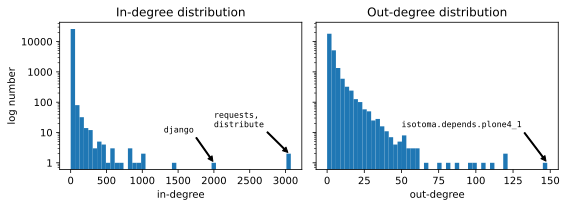

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

indegrees = sorted(g.in_degree(), reverse=True, key=lambda x: x[1])
outdegrees = sorted(g.out_degree(), reverse=True, key=lambda x: x[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), sharey='row')
ax1.hist([x[1] for x in indegrees], bins=50)
ax1.set_yscale('log')
ax1.get_yaxis().set_major_formatter(ScalarFormatter())
ax1.set_ylabel('log number')
ax1.set_xlabel('in-degree')
ax1.set_title('In-degree distribution')
ax1.annotate('requests,\ndistribute', family='monospace',fontsize='smaller', xy=(3050, 2), xytext=(2000, 15),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5, headlength=5))
ax1.annotate('django', family='monospace',fontsize='smaller', xy=(2000, 1), xytext=(1300, 10),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5, headlength=5))
ax2.hist([x[1] for x in outdegrees], bins=50)
ax2.set_yscale('log')
ax2.get_yaxis().set_major_formatter(ScalarFormatter())
ax2.set_xlabel('out-degree')
ax2.set_title('Out-degree distribution')
ax2.annotate('isotoma.depends.plone4_1', family='monospace',fontsize='smaller', xy=(148, 1), xytext=(50, 15),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5, headlength=5))
fig.tight_layout()
pprint(indegrees[:5])
pprint(outdegrees[:5])

The obtained degree distributions are quite different but they share one important similarity: a distribution tail which is not negligible and contains few important outliers. On the in-degree distribution diagram, those are packages which are required by many other packages such as `requests`, a popular library which simplifies making HTTP requests. On the out-degree diagram, the highest number of requirements are posed by packages which act as cover packages, e.g., `isotoma.depends.plone4_1` which just depends on all the packages needed by `Plone 4.1`, a very popular CMS.

Let's now focus on the node2vec library. This particular implementation features Gensim's interface as in the `Word2Vec` class. This feature greatly simplifies many tasks and aligns the node2vec algorithm to the word2vec algorithm. First, we will run the node2vec with the increased default parameters which is safe because of relatively "small" size of the network. We will use 500 random walks of length 300 per node.

In [5]:
import node2vec
import random
random.seed(a=42)
n2v = node2vec.Node2Vec(g, num_walks=500, walk_length=300, workers=4)

Computing transition probabilities: 100%|██████████| 26194/26194 [00:01<00:00, 24105.53it/s]


For training the model we will use `window=10` (maximum distance between the current and predicted node within a walk) and `min_count=5` to ignore all nodes with lower frequency than this. The `fit` function accepts [all parameters]((https://radimrehurek.com/gensim/models/word2vec.html)) supported by the Gensim's `Word2vec` and returns a `Word2vec` class instance.

In [6]:
model = n2v.fit(window=10, min_count=5)

Now the computed model can be used for querying just like a word2vec instance. While we cannot expect to get the same level of quality in the answers because the network contains only the information about package interdependency, the results should at least be interpretable.

In [16]:
print(model.wv.doesnt_match(['scipy', 'numpy', 'matplotlib', 'seaborn', 'unidecode']))
pprint(model.wv.most_similar('networkx', topn=5))
pprint(model.wv.most_similar_to_given('django', ['plone', 'gensim', 'matplotlib', 'scikit-learn', 'spacy']))

unidecode
[('python-louvain', 0.7084739804267883),
 ('streetnames', 0.6887220144271851),
 ('pypdt', 0.6871433258056641),
 ('distance', 0.6849218606948853),
 ('astropysics', 0.6805448532104492)]
'plone'


The obtained results indicate that the methods works well. First, `unidecode` is indeed different because the rest are scientific libraries while `unidecode` is a library for ASCII transliteration of unicode text. Second, `pydotplus` was found to be most similar to `networkx` which is true as both are dealing with networks (`pydotplus` is an interface to the Graphviz's Dot language). Finally, `django` is definitely more similar to `plone` (a well known CMS) than to other listed packages. Let us state again that the similarity as measured here is based on package dependency which is only weakly related to the actual main functionality of packages but evidently enough because the results can be easily interpreted.

To obain the $NxK$ matrix which holds node embeddings as rows we simply extract node vectors and construct an array.

In [8]:
import numpy as np
node_embeddings = np.array([model.wv.get_vector(node) for node in model.wv.vocab])
print(node_embeddings.shape)

(26194, 128)


Node embeddings can be used in visualization. Let's try to visualize node embeddings in 2D space using t-SNE to see if we get any dense and nicely separated clusters.

In [17]:
from sklearn.manifold import TSNE
node_embeddings_2D = TSNE(n_components=2).fit_transform(node_embeddings)

To draw the complete data we must keep the size of points small. The obtained scatterplot suggests that there are several smaller clusters of similar nodes and a large number of non-specific nodes which are dispersed. Please note that t-SNE is stohastic so 2D embedding will look different on every run.

In [80]:
x = node_embeddings_2D[:,0]
y = node_embeddings_2D[:,1]
figure = plt.figure(figsize=(8, 8))
_ = plt.scatter(x, y, s=0.5, alpha=0.4)
_ = plt.axis('off')

Finally, let's try to mark some popular python packages on the scatterplot to see if any conclusions can be drawn. We will use manually compiled lists of few popular packages for each of the categories listed below where each category will use a different color:
- GUI development
- database interfaces
- web development
- scientific programming
- game development

In [79]:
gui = ['wxpython', 'pygobject', 'pmw', 'pyqt', 'pyside']
db = ['pymysql', 'pygresql', 'sqlalchemy', 'sqlite3']
web = ['beautifulsoup', 'mechanize', 'requests', 'selenium', 'pyquery', 'django']
sci = ['numpy', 'scipy', 'matplotlib', 'pandas', 'scikit-learn', 'seaborn']
game = ['pygame', 'pyglet', 'pyopengl', 'kivy']

new_figure = plt.figure(figsize=(8, 8))
_ = plt.scatter(x, y, s=0.5, alpha=0.1)
_ = plt.axis('off')

node_labels = {node:i for i,node in enumerate(model.wv.vocab)}
for group, color in [(gui, 'red'), (db, 'green'), (web, 'orange'), (sci, 'yellow'), (game, 'magenta')]:
    for package in group:
        plt.plot(x[node_labels[package]], y[node_labels[package]], '*', color=color, mew=1, ms=7)
        plt.annotate(package, (x[node_labels[package]], y[node_labels[package]]), fontsize=6)

The results can be easily interpreted. Scientific packages form the tightest cluster as their dependency connections are very similar. The same holds for game development packages and database interfaces. GUI development libraries are less consistent, and web development libraries are the most diverse. This is not surprising because the list contains packages for very different purposes, e.g., `django` (web framework) and `mechanize` (programmatic web browsing).